In [1]:
from instant_ack import *

%load_ext autoreload
%autoreload 2

2024-09-11 00:30:36.653 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Load data

In [2]:
df = cv.load_data("qlog", skip_missing=True).filter(
    pl.col("meta_name") == "large_file", pl.col("server_group") == "WFC"
)

In [3]:
# Get updates according to RFC
df_rfc = df.filter(
    # Isolate only ACKs, other datapoints are caused by recalculation of PTO due to handshake_confirmed
    pl.col("cc_newly_acked_ack_eliciting")
    == True,
).with_columns(Source=pl.lit("Packets with new ACKs"))

In [4]:
relevant_cols = ["data_smoothed_rtt", "data_rtt_variance"]

df_mtr = (
    df.filter(
        pl.col("name") == "recovery:metrics_updated",
        # Some implementations have an initial log, which contains the default informations, we remove those
        ~(
            (pl.col("client") == "quic-go")
            & (pl.col("data_smoothed_rtt") == 0)
            & (pl.col("data_rtt_variance") == 0)
        ),
        ~(
            (pl.col("client") == "quiche")
            & (pl.col("data_smoothed_rtt") == 333)
            & (pl.col("data_rtt_variance") == 166.5)
        ),
        ~(
            (pl.col("client") == "ngtcp2")
            & (pl.col("data_smoothed_rtt") == 100)
            & (pl.col("data_rtt_variance") == 50)
        ),
        pl.col("time_since_first_ms") != 0,
    )
    .with_columns(
        pl.col(relevant_cols).forward_fill().over("file"),
        Source=pl.lit("recovery:metric updates"),
    )
    .filter(
        # At least one value must be non null
        pl.col("data_smoothed_rtt").is_not_null()
        | pl.col("data_rtt_variance").is_not_null(),
    )
    .with_row_index("idx")
    .filter(
        # We consider an update when either data_smoothed_rtt changes or data_rtt_variance does so
        (pl.col("data_smoothed_rtt") != pl.col("data_smoothed_rtt").shift()).over(
            "file"
        )
        | (pl.col("data_rtt_variance") != pl.col("data_rtt_variance").shift()).over(
            "file"
        )
        | (pl.col("idx") == pl.col("idx").min().over("file")),
    )
)

In [5]:
group = ["file", "client", "scenario", "Source"]
columns = group

enum = list(df_rfc.select("client").unique("client").sort("client").collect()["client"])

data = (
    pl.concat([df_mtr, df_rfc], how="diagonal")
    .select(columns)
    .group_by(group)
    .len()
    .sort("client")
)

# Plot

### RTT samples: Appendix E, Figure 12

All groups of ['client', 'Source'] had 100 unique files. All OK!


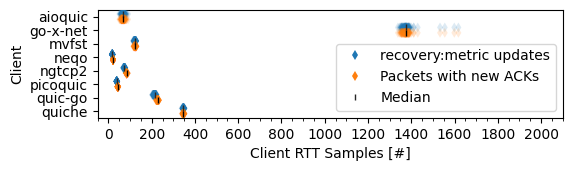

In [6]:
plot.strip(
    data.filter(pl.col("scenario") == "goodput").collect(),
    xlabel="Client RTT Samples [#]",
    x="len",
    ylabel="Client",
    y="client",
    hue="Source",
    xMajorLocator=ticker.MultipleLocator(200),
    xMinorLocator=ticker.MultipleLocator(50),
    xlim=(-50, 2100),
    legend_ncol=1,
    legend_pos="lower right",
    dest="interop-runner/str_rtt_samples_loss_goodput",
    median=True,
)

In [7]:
data.filter(pl.col("scenario") == "goodput").collect().filter(
    pl.col("client") == "quiche"
).sort("file")

file,client,scenario,Source,len
str,str,str,str,u32
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""recovery:metric updates""",343
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""Packets with new ACKs""",343
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""Packets with new ACKs""",350
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""recovery:metric updates""",350
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""recovery:metric updates""",348
…,…,…,…,…
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""recovery:metric updates""",346
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""recovery:metric updates""",341
"""/data/instant-ack/data/raw/int…","""quiche""","""goodput""","""Packets with new ACKs""",341


NOT all groups of ['client', 'Source'] had 100 unique files. You may want to verify what happened to the subsequent folders


client,Source,file_n
str,str,u32
"""quiche""","""recovery:metric updates""",1
"""quiche""","""Packets with new ACKs""",1


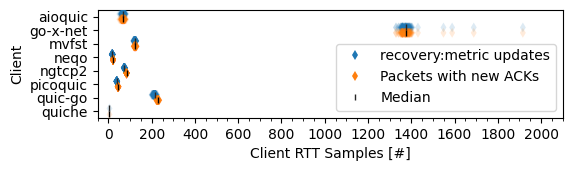

In [8]:
plot.strip(
    data.filter(pl.col("scenario") == "goodputdroplist").collect(),
    xlabel="Client RTT Samples [#]",
    x="len",
    ylabel="Client",
    y="client",
    hue="Source",
    xMajorLocator=ticker.MultipleLocator(200),
    xMinorLocator=ticker.MultipleLocator(50),
    xlim=(-50, 2100),
    legend_ncol=1,
    legend_pos="lower right",
    dest="interop-runner/str_rtt_samples_loss_goodput_droplist",
)

All groups of ['client', 'Source'] had 100 unique files. All OK!


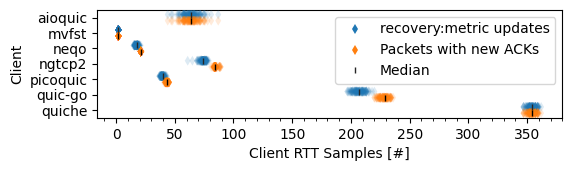

In [9]:
plot.strip(
    data.filter(pl.col("scenario") == "http3c").collect(),
    xlabel="Client RTT Samples [#]",
    x="len",
    ylabel="Client",
    y="client",
    hue="Source",
    xMajorLocator=ticker.MultipleLocator(50),
    xMinorLocator=ticker.MultipleLocator(10),
    # xlim=(0, 360),
    legend_ncol=1,
    legend_pos="upper right",
    dest="interop-runner/str_rtt_samples_loss_http3",
    median=True,
)

In [10]:
data.filter(pl.col("scenario") == "http3c", pl.col("client") == "mvfst").collect()

file,client,scenario,Source,len
str,str,str,str,u32
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""Packets with new ACKs""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""Packets with new ACKs""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""recovery:metric updates""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""Packets with new ACKs""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""recovery:metric updates""",2
…,…,…,…,…
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""recovery:metric updates""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""recovery:metric updates""",2
"""/data/instant-ack/data/raw/int…","""mvfst""","""http3c""","""recovery:metric updates""",2
